In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square
from scipy.integrate import quad
from numpy import sqrt, exp, pi, cos, sin, log
from scipy.stats import norm
import pandas as pd
from time import perf_counter
from tqdm.notebook  import tqdm

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')
np.seterr(all = 'ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

# Part 1
----------------------------------------------------------------
from Medium.com : https://medium.com/@alexander.tsoskounoglou/pricing-options-with-fourier-series-p1-5bf60443ba0c 

# Introduciton

For a function $f(x)$ with for a range a,b we can transform it as:
$$\begin{align*}
& f(x) &\approx& A_0 + \sum_{n=1}^{\infty}A_n*cos\bigg(\frac{2\pi xn}{L}\bigg) + B_n*sin\bigg(\frac{2\pi xn}{L}\bigg) \\
& A_0  &=& \frac{1}{L}\int_{-L/2}^{L/2} f(x)dx \quad for \; n\ge 1\\
& A_n  &=& \frac{2}{L}\int_{-L/2}^{L/2} f(x)*cos\bigg(\frac{2\pi xn}{L}\bigg)dx \quad for \; n\ge 1\\
& B_n  &=& \frac{2}{L}\int_{-L/2}^{L/2} f(x)*sin\bigg(\frac{2\pi xn}{L}\bigg)dx \quad for \; n\ge 1\\
\end{align*}$$

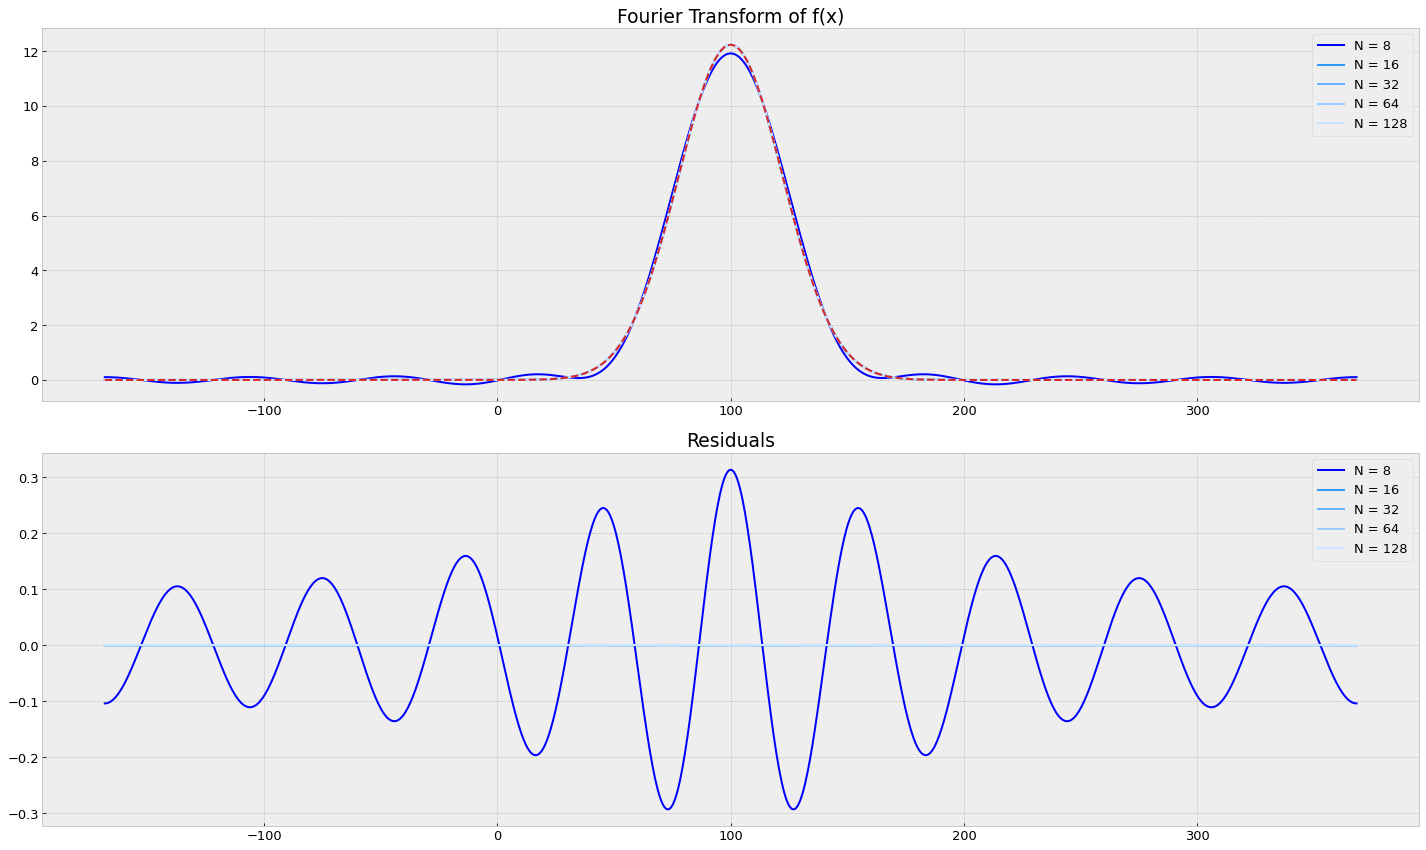

,Avg Residual
8,1.092374e-01
16,8.326020e-05
32,6.878539e-14
64,5.721031e-14
128,5.170898e-14


In [41]:
def get_fourier_approx(f, x:np.array, a:float, b:float, N:int):
    L = b - a
    upper = L/2
    lower = - upper

    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(L))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(L))

    A0 = (1/L) * quad(f, lower, upper, limit=200)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = (2/L) * quad(fa, lower, upper, args=(n), limit=200)[0]
        B = (2/L) * quad(fb, lower, upper, args=(n), limit=200)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(L)) + B*sin((2*pi*n*x)/(L))

    fx = A0 + Cosine_Sine_Sum
    return fx


mean = 100
std  = .1 *sqrt(5)*100 
f = lambda x : (1/(std*sqrt(2*pi))) * exp(-(x-mean)**2/(2*std**2)) *12/0.0175
# f = lambda x : square(x)*6
# f = lambda x : x

a = 100 - 12 * std
b = 100 + 12 * std
x = np.linspace(a, b, 1_000)
y = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
blue_shades = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,y-fx, blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title('Fourier Transform of f(x)')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend();ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

# Log normal distribution of $S_t$
$$\begin{align*}
& S_T &=& S_0 exp\bigg\{(r-\frac{1}{2}\sigma^2)T + \sigma\sqrt{T}Z \bigg\} &\\
& Z(S_T) &=& \frac{ln(\frac{S_T}{S_0}) - (r - \frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}} \quad &,S_T > 0 \\
& Z(S_T) &=& -\inf \quad &,S_T \le 0 \\
& f(S_T) &=& \frac{1}{\sqrt{2\pi}}exp\bigg\{-\frac{Z(S_T)^2}{2}\bigg\} & \\
& a &=& S_0e^{r*T} - 12 \sigma\sqrt{T}S_0 \\
& b &=& S_0e^{r*T} + 12 \sigma\sqrt{T}S_0 \\
\end{align*}$$

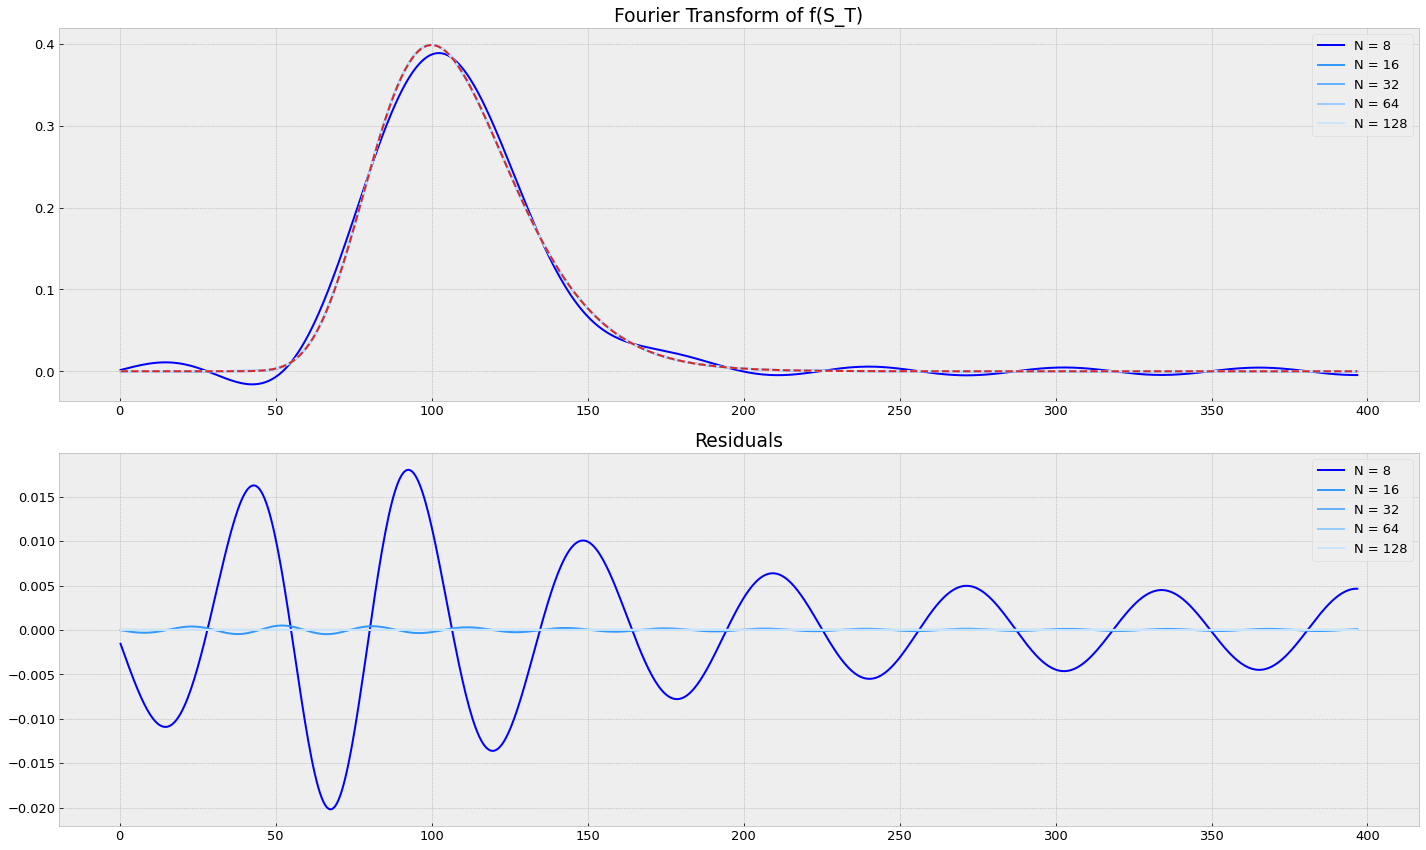

,Avg Residual
8,5.880975e-03
16,1.411566e-04
32,9.855127e-07
64,8.918504e-07
128,8.530034e-07


In [43]:
def get_fourier_approx(f, x:np.array, a, b, N:int):
    limit =1000
    L = b - a
    upper = L/2
    lower = - upper
    # print(f"L = {L} \nupper = {upper} \nlower = {lower}")

    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(L))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(L))

    A0 = (1/L) * quad(f, lower, upper, limit=limit)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = (2/L) * quad(fa, lower, upper, args=(n), limit=limit)[0]
        B = (2/L) * quad(fb, lower, upper, args=(n), limit=limit)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(L)) + B*sin((2*pi*n*x)/(L))

    fx = A0 + Cosine_Sine_Sum
    return fx


S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

Z = lambda St : np.where(St > 0, ((log(St/S0) - (r - .5*sigma)*T)/(sqrt(T)*sigma)), -np.inf)
f = lambda x : norm.pdf(Z(x)) #*2.5*12 # SCALING FOR Y MAX = 12

# Try changing a = 1e-8 to see the undesirable effect of not having symetrical limits.
# The limits of the plot are modified to start from zero since S_T cannot be less than 0
a   = S0*exp(r*T) - 12 * sigma*sqrt(T)*S0 
b   = S0*exp(r*T) + 12 * sigma*sqrt(T)*S0
x   = np.linspace(a, b, 1_000)
idx = x>0
y   = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
blue_shades = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x[idx],fx[idx], blue_shades[i], label=f'N = {N}')
    ax2.plot(x[idx],(y-fx)[idx], blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y[idx]-fx[idx]).mean())

ax1.set_title('Fourier Transform of f(S_T)')
ax1.plot(x[idx],y[idx],'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

## Timeings

In [31]:
x = np.array([100.0])
Ns = [8, 16, 32, 64, 128]
timings = []
for i, N in tqdm(enumerate(Ns), total=5):
    avg_time = []
    for _ in range(10):
        t = perf_counter()
        _ = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
        avg_time.append(perf_counter() - t)
    timings.append(np.mean(avg_time))

pd.DataFrame(timings, index=Ns, columns=['Execution Time'])

  0%|          | 0/5 [00:00<?, ?it/s]

,Execution Time
8,0.112720
16,0.246473
32,0.624209
64,1.936948
128,6.741019


In [33]:
"""
N       Avg. (scaled) Residual      Avg. Residual       Execution Time (sec)
----------------------------------------------------------------------------
8	    0.176429                    5.880975e-03        0.112720 
16	    0.004235                    1.411566e-04        0.246473 
32	    0.000030 	                9.855127e-07        0.624209 
64	    0.000027 	                8.918504e-07        1.936948 
128	    0.000026 	                8.530034e-07        6.741019
""" ; 